In [1]:
# pip install xarray cfgrib pandas numpy  (and have ecCodes installed)
import xarray as xr
import pandas as pd

grib = "D.grib"

# --- Open by shortName (GRIB naming) ---
# 2m temperature = '2t'   (Kelvin)
t2_ds = xr.open_dataset(grib, engine="cfgrib",
                        backend_kwargs={"filter_by_keys": {"shortName": "2t", "typeOfLevel": "surface"}},
                        decode_timedelta=True)
# total precipitation = 'tp' (meters, accumulated)
tp_ds = xr.open_dataset(grib, engine="cfgrib",
                        backend_kwargs={"filter_by_keys": {"shortName": "tp", "typeOfLevel": "surface"}},
                        decode_timedelta=True)

def collapse_time_step_to_time(da, ds):
    """
    da: DataArray with dims ('time','step', lat, lon)
    ds: its parent Dataset, which contains 2D coord 'valid_time' of shape (time, step)
    returns: DataArray with dims ('time', lat, lon) using valid_time as the axis
    """
    # 1) Avoid name clash with new 'time' by renaming the original time dim
    da = da.rename({"time": "init_time"})
    vt = ds["valid_time"].rename({"time": "init_time"})  # dims: ('init_time','step')

    # 2) Flatten (init_time, step) → 'ts'
    da_flat = da.stack(ts=("init_time", "step"))
    vt_flat = vt.stack(ts=("init_time", "step"))

    # 3) Attach the real timestamps and swap to a true time axis
    da_flat = da_flat.assign_coords(time=("ts", vt_flat.values))
    da_flat = da_flat.swap_dims({"ts": "time"}).sortby("time")

    # 4) Clean up leftover index-level coords if present
    for name in ["ts", "init_time", "step"]:
        if name in da_flat.coords:
            try:
                da_flat = da_flat.drop_vars(name)
            except Exception:
                pass

    # Some ERA5 files have a singleton 'number' or 'expver' dim; squeeze it
    for d in ("number", "expver"):
        if d in da_flat.dims and da_flat.sizes[d] == 1:
            da_flat = da_flat.isel({d: 0}, drop=True)

    return da_flat

# --- Use it on your precip ---
# tp_ds = xr.open_dataset(..., engine="cfgrib", filter_by_keys={"shortName":"tp","typeOfLevel":"surface"})
tp_mm = tp_ds["tp"] * 1000.0  # m → mm

if "step" in tp_mm.dims and "valid_time" in tp_ds:
    tp_mm = collapse_time_step_to_time(tp_mm, tp_ds)
elif "valid_time" in tp_mm.coords and "time" in tp_mm.coords:
    # If both exist but no step dim, prefer valid_time as the axis
    tp_mm = (tp_mm.swap_dims({"time": "valid_time"})
                  .drop_vars("time")
                  .rename({"valid_time": "time"}))
# else: already on a proper 1D 'time' axis → nothing to do

# Temperature (your t2m DataArray), convert and aggregate
t2_c = t2_ds.get("t2m", t2_ds.get("2t")) - 273.15

def crop_bbox(da, north, west, south, east):
    """Crop a DataArray/Dataset to [N,W,S,E], handling 0–360 or −180–180 lon and descending latitude."""
    ds = da.to_dataset(name="__tmp__") if isinstance(da, xr.DataArray) else da

    # Normalize longitude to [-180, 180]
    if ds.longitude.max() > 180:
        lon = ((ds.longitude + 180) % 360) - 180
        ds = ds.assign_coords(longitude=lon).sortby("longitude")

    # Build slices that match the coordinate order
    lat_desc = ds.latitude[0] > ds.latitude[-1]
    lat_slice = slice(north, south) if lat_desc else slice(south, north)

    lon_asc = ds.longitude[0] < ds.longitude[-1]
    lon_slice = slice(west, east) if lon_asc else slice(east, west)

    out = ds.sel(latitude=lat_slice, longitude=lon_slice)
    return out["__tmp__"] if "__tmp__" in out.data_vars else out

# ---- choose your box (example: Matif belt) ----
N, W, S, E = 55.0, -5.5, 45.0, 15.0

# After you compute t2_c and tp_mm:
t2_c  = crop_bbox(t2_c,  N, W, S, E)
tp_mm = crop_bbox(tp_mm, N, W, S, E)


daily = xr.Dataset({
    "tmean": t2_c.resample(time="1D").mean(),
    "tmin":  t2_c.resample(time="1D").min(),
    "tmax":  t2_c.resample(time="1D").max(),
    "precip_mm": tp_mm.resample(time="1D").sum(),
})

# If your precip file is the ERA5-Land 00:00-only trick (one value/day), align totals:
if int(tp_mm.resample(time="1D").count().median().item()) == 1:
    daily["precip_mm"] = daily["precip_mm"].shift(time=-1)

# Spatial mean over box
daily_mean = daily.mean(dim=[d for d in daily.dims if d != "time"])

df = (daily_mean.to_dataframe()
                 .reset_index()
                 .rename(columns={"time": "date"}))
df["date"] = pd.to_datetime(df["date"]).dt.date
df.to_csv("matif_wx_daily_restricted_D.csv", index=False)
print("Wrote matif_wx_daily.csv", df.shape)

Wrote matif_wx_daily.csv (1098, 8)


In [ ]:
import pandas as pd

wx_98_00 = pd.read_csv("matif_wx_daily_restricted_98_00.csv")
wx_01_03 = pd.read_csv("matif_wx_daily_restricted_01_03.csv")
wx_04_06 = pd.read_csv("matif_wx_daily_restricted_04_06.csv")
wx_07_09 = pd.read_csv("matif_wx_daily_restricted_07_09.csv")
wx_10_12 = pd.read_csv("matif_wx_daily_restricted_10_12.csv")
wx_13_15 = pd.read_csv("matif_wx_daily_restricted_13_15.csv")
wx_16_18 = pd.read_csv("matif_wx_daily_restricted_16_18.csv")
wx_19_21 = pd.read_csv("matif_wx_daily_restricted_19_21.csv")
wx_22_24 = pd.read_csv("matif_wx_daily_restricted_22_24.csv")
wx_25 = pd.read_csv("matif_wx_daily_restricted_25.csv")

In [7]:
wx = pd.concat([
    wx_98_00, wx_01_03, wx_04_06, wx_07_09, 
    wx_10_12, wx_13_15, wx_16_18, wx_19_21, 
    wx_22_24, wx_25
], ignore_index=True)
wx.dropna(inplace=True)

In [11]:
wx.to_csv("matif_wx_daily_all.csv", index=False)

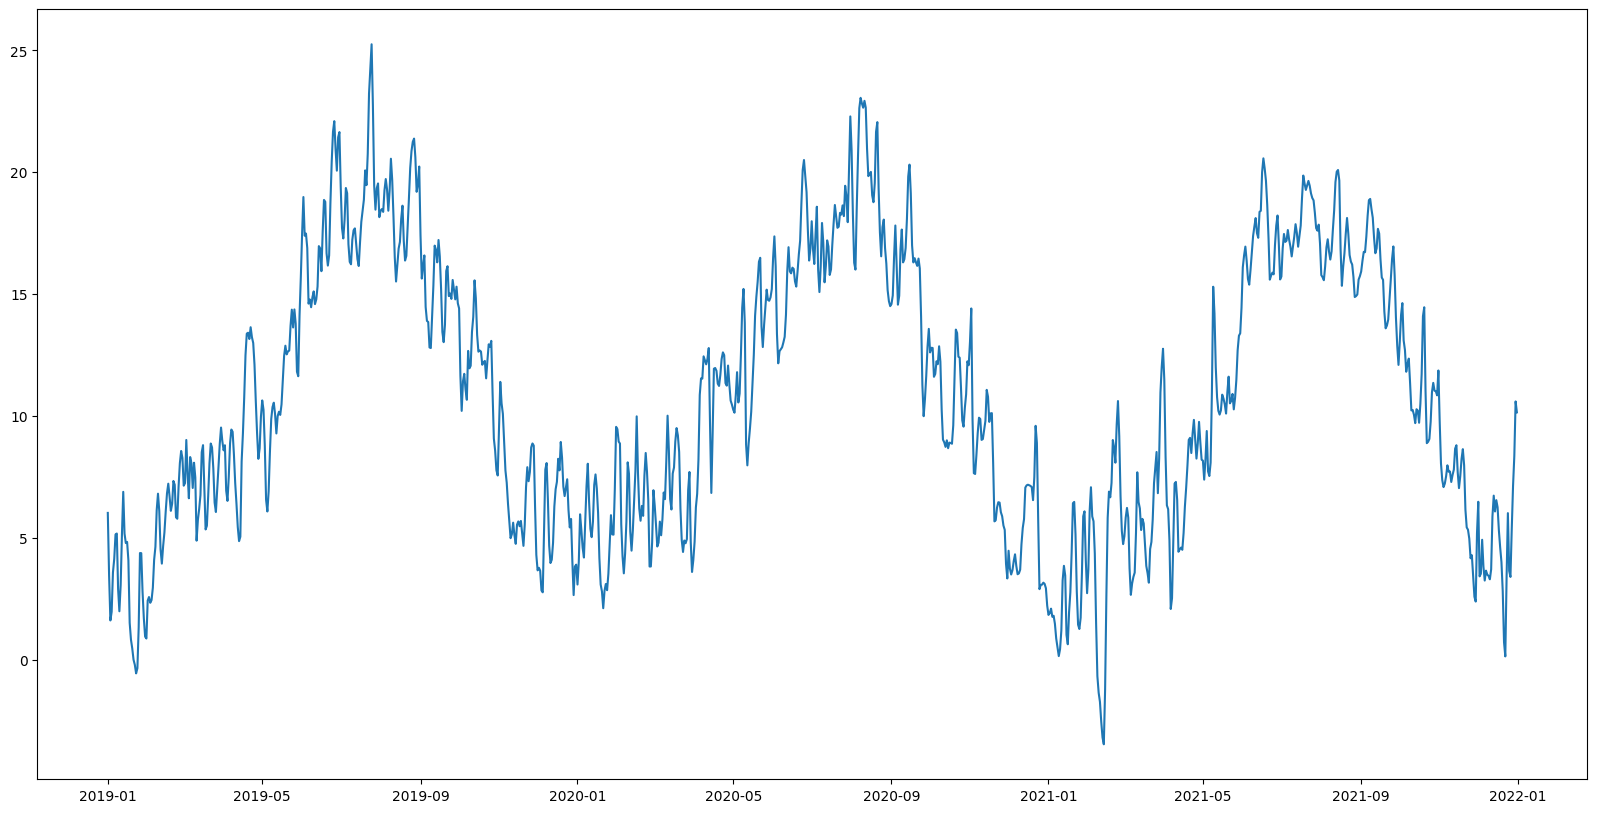

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df['date'], df["tmean"])
plt.show()

